In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

### file hierarchy and database connection vars

In [2]:
# directory & file hierarchy
iterationName = 'cdm_run_v3'
exp_path = 'museumstation'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [4]:
# wave 1 of data collection (16 classes)
experiment_name = 'cdm_run_v3'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 2359 valid sessions from cdm_run_v3.
We currently have 12528 total drawings from cdm_run_v3.
The last drawing was made at 2018-07-18T23:20:21.910Z.


### How many of these drawings are from kids and not on practice trials?

In [5]:
image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}}]})
print 'We currently have {} raw images from kids in {}.'.format(image_recs_kids.count(), iterationName)


We currently have 11276 raw images from kids in cdm_run_v3.


In [6]:
image_recs_kids_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from kids in {}.'.format(image_recs_kids_not_practice.count(), iterationName)

We currently have 6356 non-practice trials from kids in cdm_run_v3.


### Get out number of drawings per age and class

In [7]:
ages = {'age2','age3','age4','age5','age6','age7','age8','age9','age10'}
# categories = {'a bike',
# 'a bird',
# 'a boat',
# 'a bowl',
# 'a car',
# 'a chair',
# 'a couch',
# 'a cup',
# 'a dog',
# 'a fish',
# 'a house',
# 'a person',
# 'a phone',
# 'a rabbit',
# 'a tree',
# 'an airplane'}


categories = {'an airplane',
'a bike',
'a bird',
'a bowl',
'a chair',
'a couch',
'a phone',
'a rabbit'}


In [9]:
## Counts by age and clas
counts=[]
category=[]
age=[]

for thiscat in categories:
    for thisage in ages:
        thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':thisage},{'category':thiscat}]})
#         print 'We have {} drawings for {} and {} '.format(thissubset.count(),thisage, thiscat)
        counts.append(thissubset.count())
        category.append(thiscat)
        age.append(thisage)

In [10]:
# Counts by class only
cat_counts=[]
for thiscat in categories:
    thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':thiscat}]})
    cat_counts.append(thissubset.count())

In [12]:
C = pd.DataFrame([counts,category,age])
C = C.transpose()
C.columns = ['counts','category','age']

In [13]:
C

,counts,category,age
0,46,a rabbit,age10
1,26,a rabbit,age9
2,37,a rabbit,age8
3,43,a rabbit,age7
4,69,a rabbit,age6
5,82,a rabbit,age5
6,79,a rabbit,age4
7,116,a rabbit,age3
8,81,a rabbit,age2
9,45,a bird,age10


### Make some basic plots

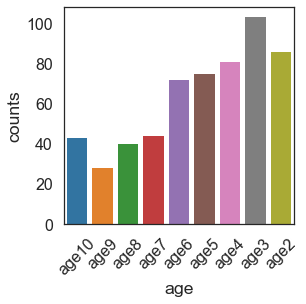

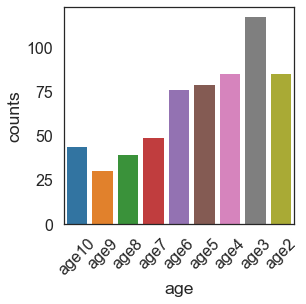

In [19]:
# df.loc[df['column_name'] == some_value]
bike = C.loc[C['category']=="a bowl"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=bike,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)
    
    
couch = C.loc[C['category']=="a couch"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=couch,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)

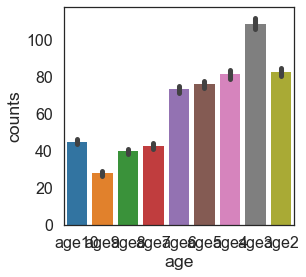

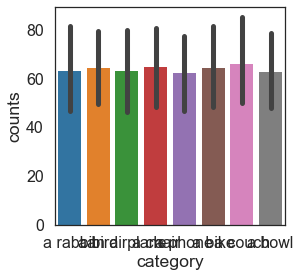

In [11]:


# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# sns.barplot(data=C,x='age',y='counts')
# # set_xticklabels(rotation=30)

# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# sns.barplot(data=C,x='category',y='counts')


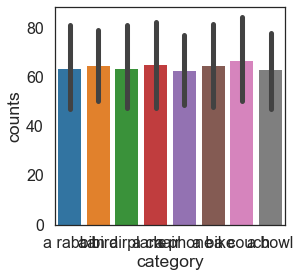

In [13]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.barplot(data=C,x='category',y='counts')


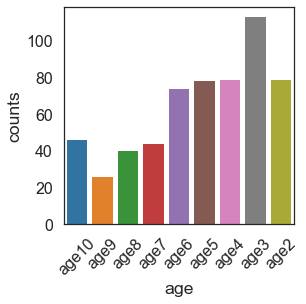

TypeError: filter() got an unexpected keyword argument 'category'

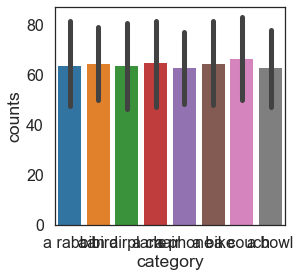

In [16]:



bike = C.filter(category=['bike'])
sns.barplot(data=bike,x='age',y='counts')

In [25]:
really_run_this = 0
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    submit_date_readable = []
    draw_duration = []
    filename = []
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:                                                            
                stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   

                if 'age' in imrec.keys():
                    if imrec['age'] != 'adult':
                        if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                            session_id.append(imrec['sessionId'])        
                            trial_num.append(imrec['trialNum']) 
                            category.append(imrec['category'])
                            age.append(imrec['age'])
                            
                            png.append(imrec['imgData'])
                            submit_time.append(imrec['time'])
                            readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
                            submit_date_readable.append(readadble_date)
                        
                            submit_date.append(imrec['date'])
                            filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
                            num_strokes.append(stroke_recs.count())
                            _svg = [] # this keeps track of the strokes from THIS final image
                            _svg_times = []
                            for strec in stroke_recs:
                                _svg.append(strec['svg'])
                                _svg_times.append(strec['time'])
                            draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                            svg.append(_svg)
                            svg_times.append(_svg_times)

                            ## and write out image data here too
                            imgData = imrec['imgData'];
                            filestr = base64.b64decode(imgData)
                            category_dir = os.path.join(sketch_dir,imrec['category'])
                            if not os.path.exists(category_dir):
                                os.makedirs(category_dir)
                            fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                        

In [38]:
submit_date_readable[-100]

'2018-05-30 16:51:21.224000'

In [39]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']

In [40]:
if really_run_this:
    X_out = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,draw_duration,filename])
    X_out = X_out.transpose()
    X_out.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','draw_duration', 'filename']

    X_out.to_csv('May31th_usage.csv')

In [9]:
# def get_bounding_box(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# merged_experiment_name = 'E1cd'

# if really_run_this:

#     ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
#     mean_intensity = []
#     bounding_box = []
#     imsize = 100
#     numpix = imsize**2
#     thresh = 250
#     for i,_d in X.iterrows():
#         imgData = _d['png']
#         filestr = base64.b64decode(imgData)
#         fname = os.path.join('sketch.png')
#         with open(fname, "wb") as fh:
#             fh.write(imgData.decode('base64'))
#         im = Image.open(fname).resize((imsize,imsize))
#         _im = np.array(im)
#         mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
#         # bounding box part
#         rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
#         bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

#     ## add to dataframe    
#     X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
#     X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
#     # save out csv
#     if not os.path.exists('../preprocessed_data'):
#         os.makedirs('../preprocessed_data')
#     X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


NameError: name 'X' is not defined

### load drawing metadata csv back in

8

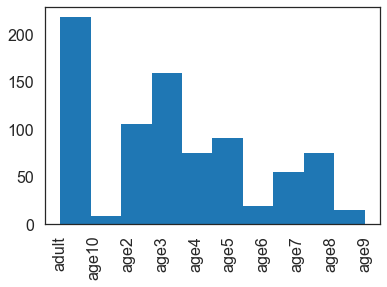

In [18]:
plt.hist(X.age,normed=False)
plt.xticks(rotation=90)
len(X.age)
sum(X.age != 'adult')

### Basic visualizations

In [16]:
np.sum(X.draw_duration.values>25)

NameError: name 'X' is not defined

Text(0.5,0,u'number of strokes')

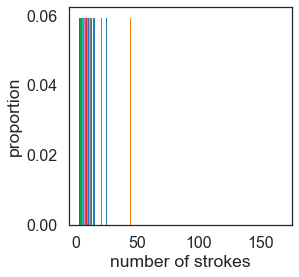

In [7]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

Text(0.5,0,u'draw duration')

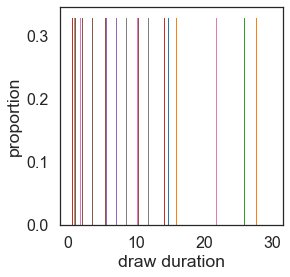

In [11]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

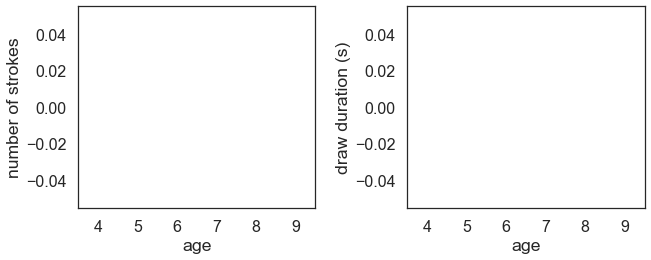

In [18]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [15]:
X.category

0                   square
1                   square
2                    shape
3                   square
4                    shape
5              this circle
6                   a fish
7                    a dog
8                    a cup
9                   a boat
10                   a car
11                 a house
12                a person
13                  a tree
14                  square
15                  square
16                   shape
17             this circle
18                  square
19                   shape
20             this circle
21                  a fish
22                  a tree
23                  a boat
24                   a dog
25                   a cup
26                a person
27                   a car
28                 a house
29      something you love
               ...        
1076                a tree
1077              a person
1078                 a cup
1079                 a car
1080                 a dog
1081                 shape
1

In [14]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

140

In [ ]:
X.

In [13]:
unique

,session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename
0,cdm_run_test1524766380234,0,square,adult,1.52477e+12,2018-04-26T18:13:19.827Z,2,"[M263,162.96875l-1,10l-1,5l-1,5l-2,7l-1,10l-2,...","[1.52476639554e+12, 1.52476639588e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0.337,/Users/brialong/Documents/GitHub/kiddraw/analy...
1,cdm_run_test1524766518460,0,square,age5,1.52477e+12,2018-04-26T18:17:34.102Z,1,"[M242,242.96875v1v1v2v2v3v2v3l-1,3v3l-1,5l-1,5...",[1.52476665118e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
3,stationPilot1_1524766676245,0,square,age5,1.52477e+12,2018-04-26T18:19:12.145Z,1,"[M232,212.96875v2v4l-1,3l-1,4l-2,3l-1,4l-1,3l-...",[1.52476674489e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
14,cdm_run_test1524767095441,0,square,age8,1.52477e+12,2018-04-26T18:30:05.270Z,135,"[M242,216.96875v3l-1,4l-1,4l-2,6l-1,5l-1,7l-1,...","[1.5247673804e+12, 1.52476738661e+12, 1.524767...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,22.229,/Users/brialong/Documents/GitHub/kiddraw/analy...
15,stationPilot1_1524767406267,0,square,age8,1.52477e+12,2018-04-26T18:30:30.271Z,2,"[M234,225.96875v1v1v1v1v1v1v1v1v2v2v2v3v2v4v3v...","[1.52476741993e+12, 1.52476742888e+12]",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,8.952,/Users/brialong/Documents/GitHub/kiddraw/analy...
18,stationPilot1_1524767460609,0,square,age9,1.52477e+12,2018-04-26T18:31:43.009Z,1,"[M265,248.96875v2v1v1h-1l-1,1h-1l-1,1h-1l-1,1l...",[1.52476750028e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
30,stationPilot1_1524767677268,0,square,age9,1.52477e+12,2018-04-26T18:35:11.560Z,1,"[M221,230.96875v1v2v2l1,1v2l1,1v1v2v1l1,1v2v2v...",[1.52476771043e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
32,cdm_run_test1524767999442,0,square,age8,1.52477e+12,2018-04-26T18:40:30.873Z,1,"[M189,222.96875v2v1v1v2v1v1v2l1,1v2l1,3l1,4l1,...",[1.52476802937e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
33,stationPilot1_1524768031714,0,square,age10,1.52477e+12,2018-04-26T18:41:05.915Z,1,"[M231,233.96875v1v1v1v1v2v2v1v2v2v2v1v1v1v2v1v...",[1.52476806297e+12],iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,0,/Users/brialong/Documents/GitHub/kiddraw/analy...
40,stationPilot1_1524768165944,0,square,age9,1.52477e+12,2018-04-26T18:43:18.263Z,9,"[M228,543.96875l-5,-9l-4,-9l-2,-5l-3,-5l9,-34l...","[1.52476818331e+12, 1.52476818799e+12, 1.52476...",iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAA...,11.481,/Users/brialong/Documents/GitHub/kiddraw/analy...


In [17]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat

1106
[78, 78, 82, 78, 82, 79, 80, 76, 135, 48, 172, 118]
